In [1]:
import pickle
import pandas as pd
import numpy as np
from scipy.stats import ranksums,wilcoxon
import cmasher as cmr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
from tqdm import tqdm

In [2]:
with open('pkl/emoprox2_dataset_timeseries+inputs.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
orig_df = orig_df[orig_df['pid'].isin(subj_list)]

In [3]:
K = 5
D = 10
N = 100
num_subjs = 92
M=20
model_num=2

In [4]:
with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{122}subjs_{model_num}.pkl','rb') as f:
        model,q,elbos,resampled_subj_list = pickle.load(f)

resampled_df = []
for pid in resampled_subj_list:
    resampled_df.append(orig_df[orig_df['pid']==pid])
resampled_df = pd.concat(resampled_df).reset_index().drop('index',axis=1)

df = resampled_df

df['continuous_states'] = [None]*df.shape[0]
df['discrete_states'] =[None]*df.shape[0]
hrflag=0
prox_bins = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
dir_bins = [0]
nprox = len(prox_bins)+1
ndir = len(dir_bins)+1
for idx_row in range(df.shape[0]):
    prox = df.loc[idx_row]['proximity']
    prox = prox - prox.min()
    prox = prox / prox.max()
    proxd = np.digitize(prox, bins=prox_bins)
    dird = 1-np.digitize(df.loc[idx_row]['direction'], bins=dir_bins)
    stim_category = (nprox*ndir-1)*dird+((-1)**dird)*proxd
    input = np.roll(np.eye(nprox*ndir)[stim_category],shift=hrflag,axis=0)

    y = df.loc[idx_row]['timeseries']
    x = q.mean_continuous_states[idx_row]
    z = model.most_likely_states(x,y)
    df.at[idx_row,'continuous_states'] = x
    df.at[idx_row,'discrete_states'] = z
    prox = df.loc[idx_row]['proximity']
    prox = prox - prox.min()
    prox = prox / prox.max()
    df.at[idx_row,'proximity'] = prox

[0.6775490884721168, 0.7366855367257966, 0.7945591654846419, 0.834303961039447, 0.8620052732839487, 0.9936520051166021]


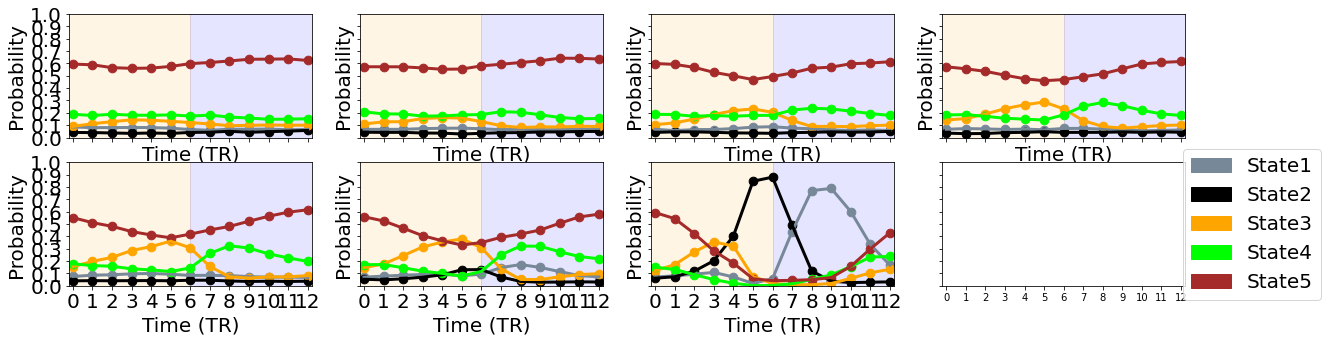

In [5]:
from scipy.signal import argrelextrema
colors = [to_rgba(c) for c in ['lightslategray','black','orange','lime','brown','red','blue','pink',]]
state_names = [f'State{i+1}' for i in range(K)]
# state_names = ['post-shock','shock','far','retreat','???','near']

def find_windows_and_local_maxima(values, window_length, hrf_lag=3):
    local_maxima_indices = argrelextrema(values, np.greater)[0]
    windows = []
    local_maxima = []

    for idx in local_maxima_indices:
        if idx - window_length // 2 + hrf_lag >= 0 and idx + window_length // 2 + hrf_lag < len(values) :
            window_start = idx - window_length // 2 + hrf_lag
            window_end = idx + window_length // 2 + hrf_lag
            windows.append((window_start, window_end))
            local_maxima.append(values[idx])

    return windows, local_maxima

local_maxima_all = []
windows_all = []
states_all_windows = []
for idx_row in range(df.shape[0]):
    prox = df.loc[idx_row]['proximity']
    censor = df.loc[idx_row]['censor'][:,0]
    states = df.loc[idx_row]['discrete_states']
    
    window_length = 12
    windows, local_maxima = find_windows_and_local_maxima(prox, window_length)
    local_maxima_all += local_maxima
    windows_all += windows
    states_all_windows += [states[l:r+1] for l,r in windows]

states_all_windows = np.vstack(states_all_windows)
local_maxima_all = np.array(local_maxima_all)

local_maxima_bins = [np.quantile(local_maxima_all,i) for i in np.arange(0,1,1/7)[1:]]
print(local_maxima_bins)
bin_indices = np.digitize(local_maxima_all,bins=local_maxima_bins)
ncols=4
fig,axs = plt.subplots(nrows=2, ncols=ncols, figsize=(20,5), sharex=True, sharey=True)
proxbin=6
for i_bin in range(len(local_maxima_bins)+1):
    ax = axs[i_bin//ncols][i_bin%ncols]
    # find states coresponding to all windows belonging to that bin
    z_bin = states_all_windows[bin_indices==i_bin,:]
    state_window_probs = np.stack(
        [np.array([(z_bin[:,tr]==k).sum() for k in range(model.K)])
          for tr in range(z_bin.shape[1])]
          ,axis=1)
    state_window_probs = state_window_probs / state_window_probs.sum(axis=0)
    
    ax.axvspan(-1,6,alpha=0.1, color='orange')
    ax.axvspan(6,13,alpha=0.1, color='blue')
    for k in range(K):
        ax.plot(state_window_probs[k,:],color=colors[k],label=state_names[k],linewidth=3)
        ax.scatter(np.arange(z_bin.shape[1]),state_window_probs[k,:],color=colors[k],s=75)
    ax.set_xticks(np.arange(z_bin.shape[1]))
    ax.set_xticklabels(np.arange(z_bin.shape[1]),fontsize=20,rotation=0)
    ax.set_yticks(0.1*np.arange(11))
    ax.set_xlim([0-0.2,z_bin.shape[1]-1+0.2])
    ax.set_ylim([0,1])
    ax.set_ylabel('Probability',fontsize=20)
    ax.set_xlabel('Time (TR)',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    min_prox = min(local_maxima_all[bin_indices==i_bin])
    max_prox = max(local_maxima_all[bin_indices==i_bin])
    # ax.set_title(f'max proximity $\in$ ({min_prox:.02f},{max_prox:.02f}) ',fontsize=12)
patchs = []
for state_name,color in zip(state_names,colors):
    if state_name != '???':
        patchs.append(patches.Patch(color=color, label=state_name))
# fig.delaxes(axs[ncols-1])
axs[-1][ncols-1].legend(handles=patchs,fontsize=20,ncol=1,loc='right',bbox_to_anchor=(1.6, 0.5))

In [6]:
prox_bins = list(np.arange(M//2)/(M//2))[1:]
dir_bins = [0]
nprox = len(prox_bins)+1
ndir = len(dir_bins)+1
hrf_shift=3
def get_p_state_giv_stimulus(df, shuffle_z:bool=False):

    zs = []
    stims = []
    for idx_row in range(df.shape[0]):
        z = np.copy(df.loc[idx_row]['discrete_states']) # sequence of discrete states

        # if shuffle_z is True: np.random.shuffle(z)
        if shuffle_z: z = np.roll(z,shift=np.random.randint(z.shape[0]))

        # bin proximity and direction values
        prox = np.digitize(df.loc[idx_row]['proximity'], bins=prox_bins)
        dir = 1-np.digitize(df.loc[idx_row]['direction'], bins=dir_bins)

        # take care of hrf lag
        if hrf_shift>0:
            prox = np.roll(prox,shift=hrf_shift)[hrf_shift:]
            dir = np.roll(dir,shift=hrf_shift)[hrf_shift:]
            z = z[hrf_shift:]

        # make sure lengths are consistent
        assert len(z)==len(prox)
        assert len(z)==len(dir)

        stim = (nprox*ndir-1)*dir+((-1)**dir)*prox
        stims.append(stim)
        zs.append(z)

    zs = np.hstack(zs)
    stims = np.hstack(stims)

    # calculate marginals
    prob_mat = np.zeros((K,nprox*ndir))
    for idx_state in range(K):
        for idx_stim in range(nprox*ndir):
            prob_mat[idx_state,idx_stim] = np.sum((zs==idx_state)*(stims==idx_stim))/np.sum(stims==idx_stim)
    # prob_mat = prob_mat / prob_mat.sum()
            
    return prob_mat

In [7]:
true_count_mat = get_p_state_giv_stimulus(df, shuffle_z=False)
num_null = 100
null_count_mats = []
for _ in tqdm(range(num_null)):
    null_count_mat = get_p_state_giv_stimulus(df, shuffle_z=True)
    null_count_mats.append(null_count_mat)    

100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


In [8]:
true_P = true_count_mat
null_P = np.stack(null_count_mats,axis=0)
pvals = np.zeros_like(true_P)
for idx_state in range(K):
    for idx_stim in range(nprox*ndir):
        true_val = true_P[idx_state,idx_stim]
        null_vals = null_P[:,idx_state,idx_stim]
        pvals[idx_state,idx_stim] = wilcoxon([true_val]*len(null_vals), null_vals, alternative='greater',).pvalue#(true_val > null_vals).sum()/num_null

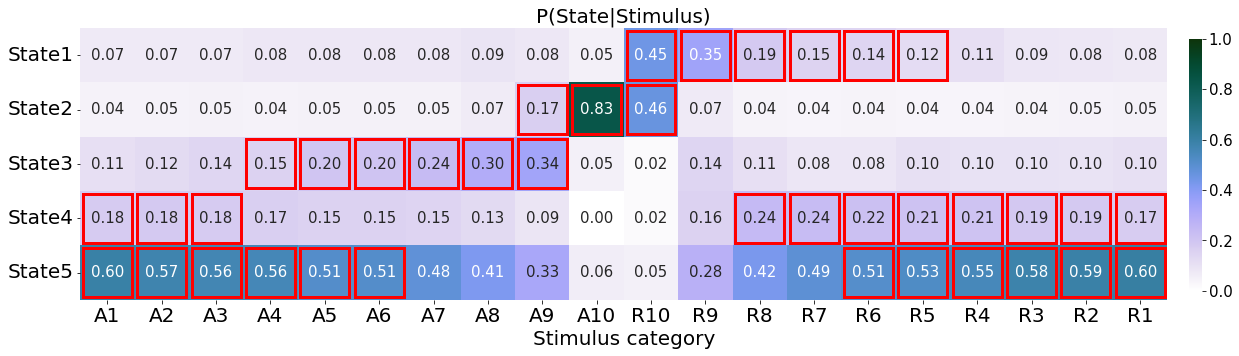

In [9]:
xticklabels = [None]*nprox*ndir
dir = 'AR'
for i in [0,1]:
    for j,prox in enumerate(prox_bins+[1]):
        xticklabels[(nprox*ndir-1)*i+((-1)**i)*j] = f"{dir[i]}{j+1}"

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(30,5), sharex=True)
sns.heatmap(
    true_P,
    annot=true_P,
    fmt='.2f', annot_kws={'size': 15},
    cmap=cmr.horizon_r,#"gist_earth",
    vmin=0,vmax=1,
    ax=ax,
    cbar=True,
    square=True,
)
for i in range(pvals.shape[0]):
    for j in range(nprox*ndir):
        if pvals[i,j] < 0.05/(nprox*ndir*K):
            ax.add_patch(
                patches.Rectangle((j+0.05,i+0.05),width=0.9,height=0.9,linewidth=3, edgecolor='red',facecolor='none')
            )

ax.set_title(r'P(State|Stimulus)'.format(idx_state=idx_state),fontsize=20) 
_ = ax.set_yticklabels([f'State{i+1}' for i in range(K)], fontsize=20, rotation=0)
_ = ax.set_xticklabels(xticklabels, fontsize=20, rotation=0)
_ = ax.set_xlabel('Stimulus category',fontsize=20)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_yticks(np.arange(6)/5)
cbar.ax.set_position([0.755,0.15,0.5,0.7])
# fig.savefig(f'figures/fig_P_state_given_stim_K{K}_D{D}_M{M}.jpg',dpi=600,bbox_inches='tight')

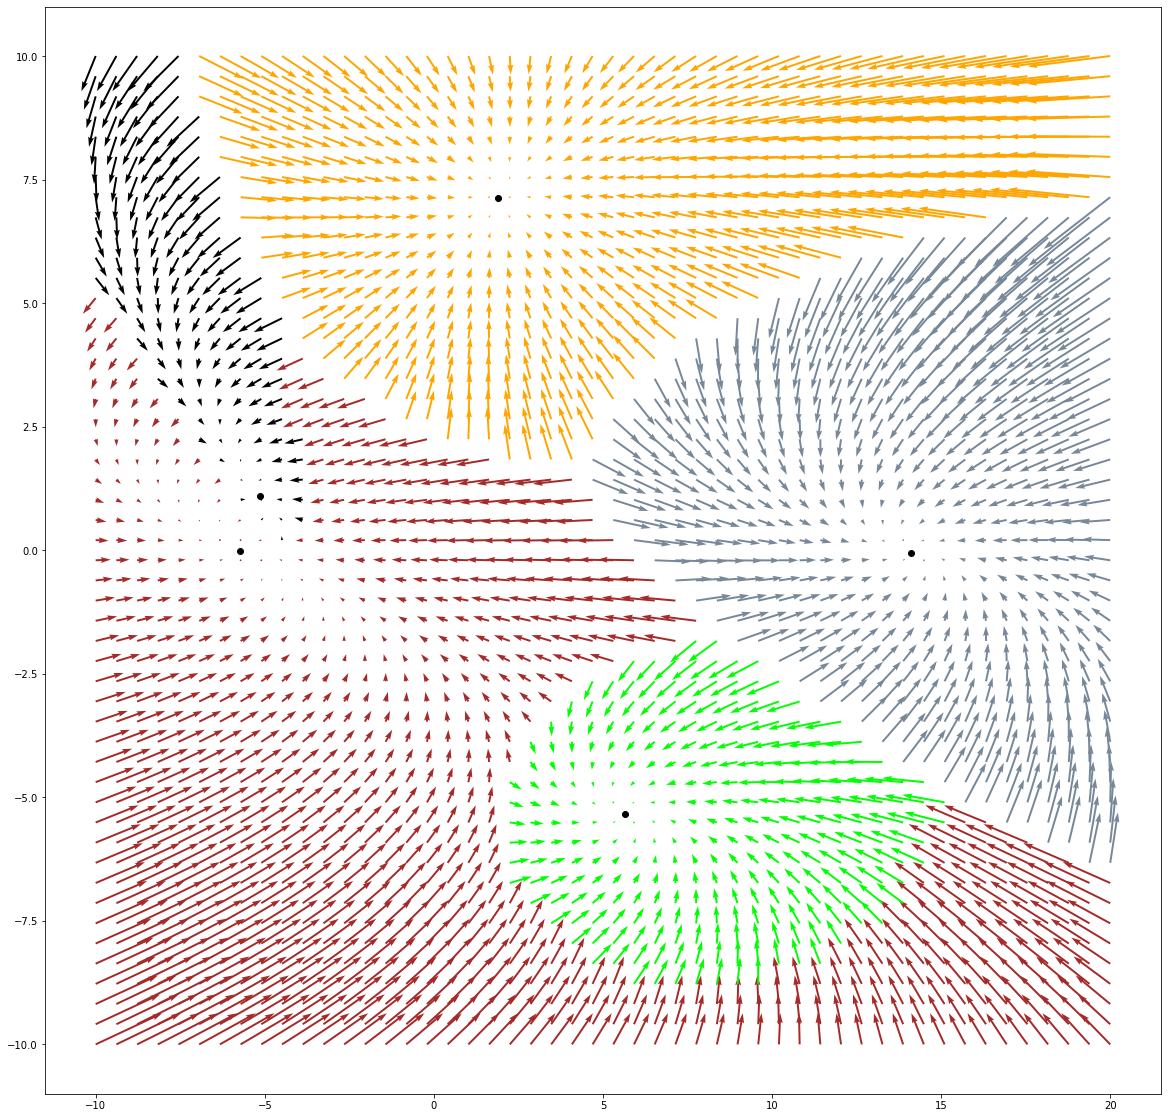

In [178]:
from pyrsistent import b
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(np.vstack(list(df['continuous_states'].values)))

As = model.dynamics.As
bs = model.dynamics.bs

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot()

# plot vector fields
xlim = [-10,20]
ylim = [-10,10]
num_points = [50,50]
colorarray = 'rgbkmcy'
xcoords = np.linspace(start=xlim[0],stop=xlim[1],num=num_points[0])
ycoords = np.linspace(start=ylim[0],stop=ylim[1],num=num_points[1])
xy = np.meshgrid(xcoords,ycoords)

# print(pca.components_.shape, pca.mean_.shape)

for v in zip(xy[0].flatten(),xy[1].flatten()):    
    shifts,norms = [],[]
    for idx_state in range(K):
        A = As[idx_state]
        b = bs[idx_state]
        fp = np.linalg.inv(np.eye(A.shape[0])-A)@b
        fp2d = (fp-pca.mean_)@pca.components_.T
        v_latent = (v-fp2d)@pca.components_ + pca.mean_
        shifts.append((A@v_latent - v_latent)@pca.components_.T)
        norms.append(np.linalg.norm(shifts[idx_state]))
    chosen_state = np.argmin(norms)
    shift = shifts[chosen_state]
    ax.quiver(v[0],v[1],shift[0],shift[1],units='xy',scale=1,width=0.05,color=colors[chosen_state])

# plot fixed points
for idx_state in range(K):
    A = As[idx_state]
    b = bs[idx_state]
    fp = np.linalg.inv(np.eye(A.shape[0])-A)@b
    # print(A@fp+b -fp)
    fp2d = (fp-pca.mean_)@pca.components_.T
    v = fp2d
    v_latent = v@pca.components_ + pca.mean_
    # print(fp,v_latent)
    ax.scatter(fp2d[0],fp2d[1],color='k')

NameError: name 'num_states' is not defined

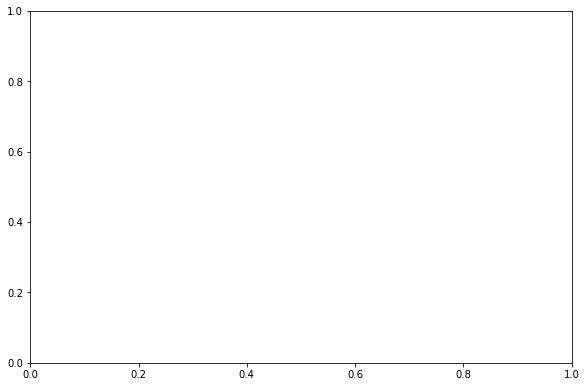

In [166]:
x_all = np.vstack(list(df['continuous_states'].values))
pca = PCA(n_components=2, )
pca.fit(x_all)
lim = 10

fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot2grid(shape=(3, 3), loc=(0, 0), colspan=2, rowspan=2)

fps = [pca.transform(attractor_x[idx_state:idx_state+1,:]+np.expand_dims(pca.mean_,axis=0)) for idx_state in range(num_states)]

for idx_state in [0,1]:

    A = As[idx_state]
    b = bs[idx_state]
    V = Vs[idx_state]
    
    x = np.linspace(-lim,lim,15)
    y = np.linspace(-lim,lim,15)
    xv,yv = np.meshgrid(x,y)
    xgrid,ygrid,dxgrid,dygrid = [],[],[],[]
    for i in range(len(x)):
        for j in range(len(y)):
            vec = np.expand_dims(np.array([xv[i,j],yv[i,j]]),axis=0)
            # ds = []
            # for i_st in range(num_states):
            #     x_0 = np.dot(vec-fps[i_st], pca.components_) 
            #     x_f = pca.transform((A@x_0.T).T+np.expand_dims(pca.mean_,axis=0))
            #     ds.append(np.linalg.norm((x_f - vec).squeeze()))
            ds = [np.linalg.norm(vec.squeeze()-fps[i_st].squeeze()) for i_st in [0,1]]
            if np.argmin(ds)==idx_state:
                vec -= fps[idx_state]
                x_0 = np.dot(vec, pca.components_) 
                x_f = pca.transform((A@x_0.T).T+np.expand_dims(pca.mean_,axis=0))
                xdiff = x_f - vec
                xgrid.append(xv[i,j])
                ygrid.append(yv[i,j])
                dxgrid.append(xdiff[:,0])
                dygrid.append(xdiff[:,1])

    # x_win = []
    # for idx_row in range(1,df.shape[0]):
    #     z = df.loc[idx_row]['discrete_states']
    #     x = df.loc[idx_row]['continuous_states']
    #     use = df.loc[idx_row]['use']

    #     idx_begin = list(np.where((z[:-1]!=idx_state)&(z[1:]==idx_state))[0]+1)
    #     idx_end = list(np.where((z[:-1]==idx_state)&(z[1:]!=idx_state))[0])
    #     if z[0] == idx_state: idx_begin = [0] + idx_begin
    #     if z[-1] == idx_state: idx_end = idx_end + [len(z)-1]
    #     assert(len(idx_begin)==len(idx_end))
    #     # for st,en in zip(idx_begin,idx_end): 
    #     #     if en-st>=10:
    #     #         print(z[st:en+1])
    #     #         assert(np.all(z[st:en+1]==idx_state))
    #     x_win += [pca.transform(np.stack(x[st:en+1],axis=0)-attractor_x[idx_state:idx_state+1,:]+np.expand_dims(pca.mean_,axis=0)) for st,en in zip(idx_begin,idx_end) if en-st>1]
    # perm = np.random.choice(len(x_win),10)
    # trajs = [x_win[i] for i in perm]

    fp = fps[idx_state]
    V = pca.transform(V.T+np.expand_dims(pca.mean_,axis=0))
    
    ax2 = plt.subplot2grid(shape=(3,3),loc=(2,idx_state),colspan=1,rowspan=1)
    for i_stim in range(20):
        ax2.quiver(0,0,V[i_stim,0],V[i_stim,1],color=cmap2(i_stim/20),alpha=1,scale=1,scale_units='xy',angles='xy',width=0.007)
    ax2.set_xlim([-1.5,1.5])
    ax2.set_ylim([-0.5,0.5])
    ax2.tick_params(left=False,right=False,labelleft=False,labelbottom=False,bottom=False)

    ax1.quiver(xgrid,ygrid,dxgrid,dygrid,color='grey',alpha=1,scale=1,scale_units='xy',width=0.004)
    
    # ax.quiver(0*V[:,0],0*V[:,1],V[:,0],V[:,1],color='k',alpha=1,scale=0.33,scale_units='xy',angles='xy',width=0.005)
    # for traj in trajs:
    #     for x1,x2 in zip(traj[:-1,:],traj[1:,:]):#[(traj[0,:],traj[-1,:])]
    #         dx = x2-x1
            # ax.quiver(x1[0],x1[1],dx[0],dx[1],color='b',alpha=0.75,scale=1,scale_units='xy',angles='xy',width=0.005)
    
    ax1.scatter(fp[:,0],fp[:,1],color='k',s=50)
    ax1.set_ylim([-lim,lim])
    ax1.set_xlim([-lim,lim])
    ax1.text(fp[:,0]-2,fp[:,1]+1,f"State{idx_state+1}", fontsize=15)
ax1.set_ylabel('PC1',fontsize=15)
ax1.set_xlabel('PC2',fontsize=15)
ax1.tick_params(left=False,right=False,labelleft=False,labelbottom=False,bottom=False)